# 2. DeepLC

In [1]:
# Import default libs
import re
import os

# Import data libs
import pandas as pd

# Import DeepLC
from deeplc import DeepLC
from deeplc import FeatExtractor

# Import plotting libs
from matplotlib import pyplot as plt
import seaborn as sns

# Supress warnings (or at least try...)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set the dir of analysis
main_dir = "DeepLC_data/"

# 2.0 Introduction

## 2.0.1 High Performance/Pressure Liquid Chromatography
As all data acquisition parts in LC-IM-MS the LC part separates analytes. In this case the separation is based on the physicochemical properties of our peptides. In most cases peptides are separated based on their hydrophobicity in so-called reverse-phase LC. A more detailed explanation is provided here: https://www.ssi.shimadzu.com/products/liquid-chromatography/knowledge-base/hplc-basics.html

This schematic representation of the instrument is the nightmare of every mass spectrometrist (i.e., this instrument is very prown to break):

![workflow_lc](images/nightmare.gif)

![workflow_lc](images/LC_workflow.png)

Source: https://www.technologynetworks.com/analysis/articles/liquid-chromatography-including-hplc-uhplc-and-lcxlc-344048



## 2.0.2 Mobile and stationary phase; migration through the column
In HPLC the separation happens in a column:

<img src="images/column.jpg" alt="column" width="200"/>

This separation is achieved with two phases, the stationary phase can look like this:
<img src="images/stat_phase.jpg" alt="stationary" width="200"/>

The sample is pumped the column with two solvents that form the mobile phase (A and B):
<img src="images/mob_phase.png" alt="mobile" width="200"/>

The analytes in the sample interact with both the stationary and mobile phase. The physicochemical properties of the peptides dictate how much they can interact with either of the two phases. (More) interaction with the mobile phase results in migration of the peptides in the column:
![workflow_lc](images/sample-bands-animation.gif)

Source: https://www.ssi.shimadzu.com/products/liquid-chromatography/knowledge-base/hplc-basics.html

# 2.1 DeepLC predictions

## 2.1.1 Reading data and preparing instances of DeepLC objects

First we will read a table that contains all of our data:

In [2]:
df = pd.read_csv("https://dl.dropboxusercontent.com/s/bok4w3jw2gxohbz/deeplc_input.csv",index_col=0)

The data looks like this:

In [3]:
print(df)

           scan  best_psm     database_peptide                  modifications  \
2             4         1              AGAVVGK                            NaN   
3             4         0              GAAAMGK                            NaN   
11          209         0              SAAAAAR                            NaN   
12          209         0           TQGSAAPGSK                 3|semi_tryptic   
13          209         1         GSETPGATPGSK                 5|semi_tryptic   
...         ...       ...                  ...                            ...   
4452830  128083         1  SIEDYSQSIHTRTISGSPR                  17|ethylamino   
4452832  128083         0  SIAASRFAPHIEKCIGMGR  8|Ala->Met|14|carbamidomethyl   
4452833  128083         0  SIAGFVASINEGMTRWFSR                    13|Met->Tyr   
4452834  128083         0   SIAEAAMYWIVNWPRPQR                    17|Gln->Thr   
4452835  128083         0   MFSISFARYGINTFVDVR                    17|Val->His   

         precursor_mass  pe

We have multiple columns describing the scan number, if a PSM is the best ranked PSM, if there are any modifications, the precursor mass, the peptide mass, the observed retention time, and the associated q-value with the PSM.

For DeepLC we need strings instead of NaN in the modifications column, so lets replace those with empty strings:

In [4]:
df.fillna("",inplace=True)

Here we sample rows from the original table, this is purely done for computational reasons (e.g., on a laptop). Feel free to increase the numbers if you have a faster system.

In [5]:
num_total_rows_select = 5000
num_calib = 250

sub_df_pred = df[df["scan"].isin(list(set(df["scan"].sample(num_total_rows_select))))]
sub_df_calib = sub_df_pred[sub_df_pred["scan"].isin(list(set(sub_df_pred[sub_df_pred["q_value"] < 0.01]["scan"].sample(num_calib))))]

Here we make sure that the column names are changed to something that DeepLC recognizes:

In [6]:
sub_df_pred.rename({
    "database_peptide" : "seq",
    "rt" : "tr"
},axis=1,inplace=True)

sub_df_calib.rename({
    "database_peptide" : "seq",
    "rt" : "tr"
},axis=1,inplace=True)

Make a feature extraction object. This step can be skipped if you want to use the default feature extraction in DeepLC. This does allow us to select for example a different file for the modifications we want to incorperate.

In [7]:
f_extractor = FeatExtractor(
                            main_path=main_dir,
                            lib_path_mod=os.path.join(main_dir, "unimod/"),
                            lib_path_prot_scale=os.path.join(main_dir, "expasy/"),
                            lib_aa_composition=os.path.join(main_dir, "aa_comp_rel.csv"),
                            lib_path_smiles=os.path.join(main_dir, "mod_to_smiles/"),
                            lib_three_to_one=os.path.join(main_dir, "expasy/three_to_one.csv"),
                            add_sum_feat=False,
                            ptm_add_feat=False,
                            ptm_subtract_feat=False,
                            standard_feat=False,
                            chem_descr_feat=False,
                            add_comp_feat=False,
                            cnn_feats=True,
                            verbose=True
)

Initiate a DeepLC instance that will perform the calibration and predictions:

In [8]:
dlc = DeepLC(
    path_model=[os.path.join(main_dir,"mods/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"),
                os.path.join(main_dir,"mods/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5"),
                os.path.join(main_dir,"mods/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5"),
                os.path.join(main_dir,"mods/full_hc_PXD005573_mcp_cb975cfdd4105f97efa0b3afffe075cc.hdf5")],
    cnn_model=True,
    f_extractor=f_extractor,
    pygam_calibration=False,
    verbose=True
)

We need to calibrate predictions to our specific LC setup to make them valid, so first we will feed some predictions to our DeepLC instance:

In [9]:
dlc.calibrate_preds(seq_df=sub_df_calib[sub_df_calib["best_psm"]==1])

Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0


1/1 [==============================] - 0s 999us/step


Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0
Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0


1/1 [==============================] - 0s 2ms/step


Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0
Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0


1/1 [==============================] - 0s 1ms/step


Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0


Going to predict retention times for this amount of identifiers: 691
Using this amount of identifiers from the library: 0


1/1 [==============================] - 0s 999us/step


Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 0.0,0.38613407135009764
Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 0.38613407135009764,0.7722681427001953
Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 0.7722681427001953,1.158402214050293
Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 1.158402214050293,1.5445362854003906
Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 1.5445362854003906,1.9306703567504881
Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 1.9306703567504881,2.316804428100586
Skipping calibration step, due to no points in the predicted range (are you sure about the split size?): 2.316804428100586,2.7029384994506835
Going to predict

You can safely ignore most errors and warnings
<img src="images/error.png" alt="mobile" width="200"/>

## 2.1.2 Is calibration a necessity?

Lets run our mode to generate predictions without calibration:

In [10]:
preds_uncal = dlc.make_preds(seq_df=sub_df_calib, calibrate=False)
sub_df_calib["preds_uncal"] = preds_uncal

Going to predict retention times for this amount of identifiers: 3600
Using this amount of identifiers from the library: 0


And lets also make calibrated predictions for the comparison:

In [11]:
preds_cal = dlc.make_preds(seq_df=sub_df_calib)
sub_df_calib["preds"] = preds_cal

Going to predict retention times for this amount of identifiers: 3600
Using this amount of identifiers from the library: 0


Now for the comparison of the two:

Uncalibrated predictions: 


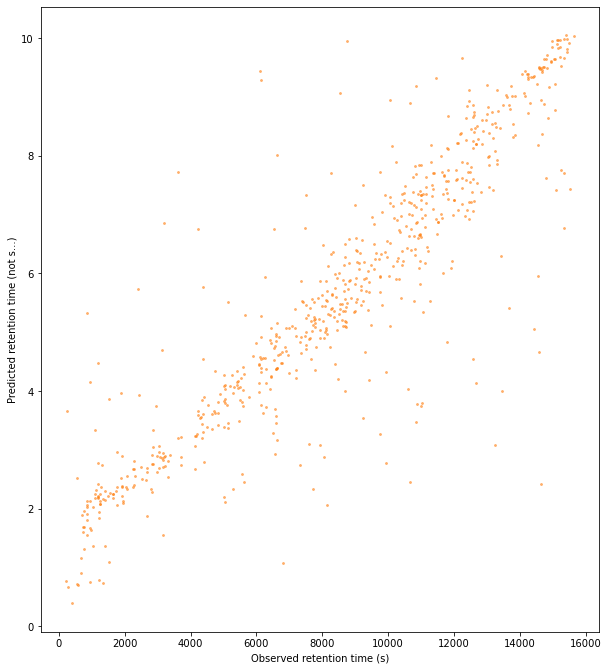

Calibrated predictions: 


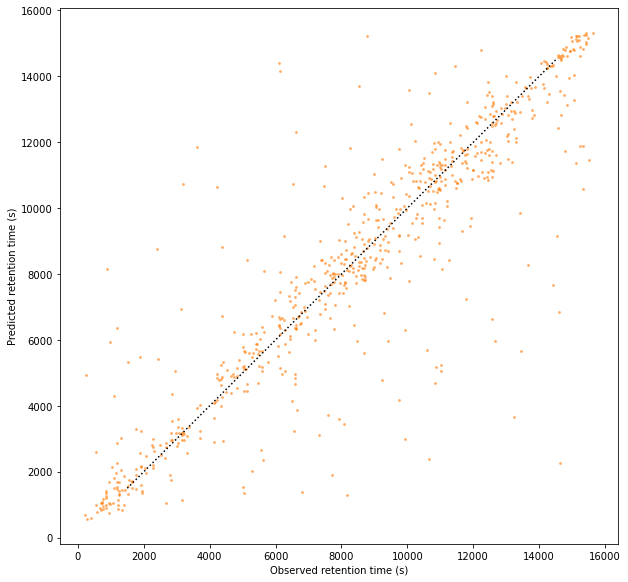

In [12]:
sub_df_calib_lowerrank = sub_df_calib[sub_df_calib["best_psm"]==0]
sub_df_calib_firstrank = sub_df_calib[sub_df_calib["best_psm"]==1]

# Init plot
plt.figure(figsize=(10,11.5))
ax = plt.gca()
#ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_calib_firstrank["tr"],sub_df_calib_firstrank["preds_uncal"],s=3.5, alpha=0.5,color="tab:orange")
plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (not s...)")

print("Uncalibrated predictions: ")
plt.show()

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

print("Calibrated predictions: ")
plt.scatter(sub_df_calib_firstrank["tr"],sub_df_calib_firstrank["preds"],s=3.5, alpha=0.5,color="tab:orange")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")
plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")

plt.show()

### 2.1.3 Questions - calibration

<ol>
  <li>Is calibration required? For what down-stream analysis would we need calibration? For which is it not required?</li>
  <li>What would be a good method for selecting calibration peptides?</li>
  <li>Do iRT peptides solve the calibration issues?</li> 
  <li>Are there other things regarding calibration you want to discuss? Like how it should probably be called alignment.</li>
</ol>

# 2.2 Prediction errors of (ranked) PSMs

## 2.2.1 Comparing rank 1 and lower ranked PSMs for the calibration set

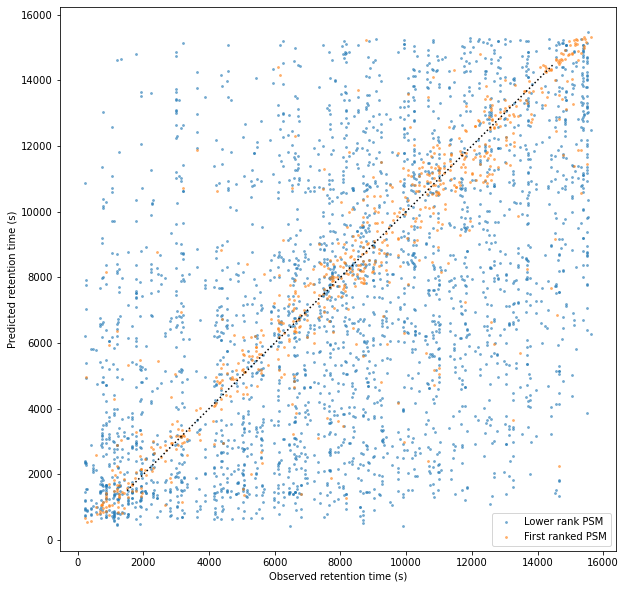

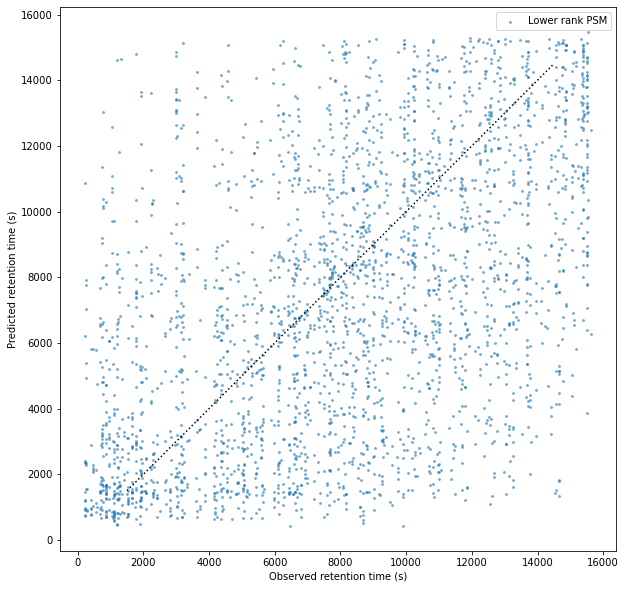

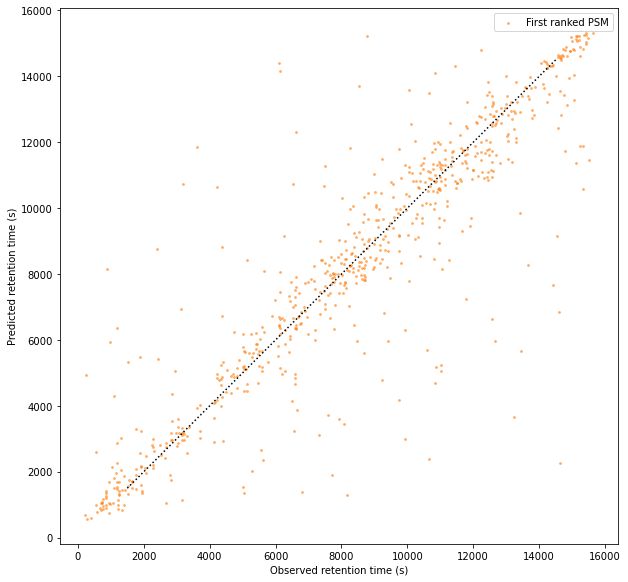

In [13]:
# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_calib_lowerrank["tr"],sub_df_calib_lowerrank["preds"],s=3.5, alpha=0.5,label="Lower rank PSM")
plt.scatter(sub_df_calib_firstrank["tr"],sub_df_calib_firstrank["preds"],s=3.5, alpha=0.5,label="First ranked PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_calib_lowerrank["tr"],sub_df_calib_lowerrank["preds"],s=3.5, alpha=0.5, color="tab:blue",label="Lower rank PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_calib_firstrank["tr"],sub_df_calib_firstrank["preds"],s=3.5, alpha=0.5, color="tab:orange",label="First ranked PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

## 2.2.2 Comparing rank 1 and lower ranked PSMs for the whole data set

Lets first make predictions:

In [14]:
preds = dlc.make_preds(seq_df=sub_df_pred)
sub_df_pred["preds"] = preds

Going to predict retention times for this amount of identifiers: 74662
Using this amount of identifiers from the library: 0


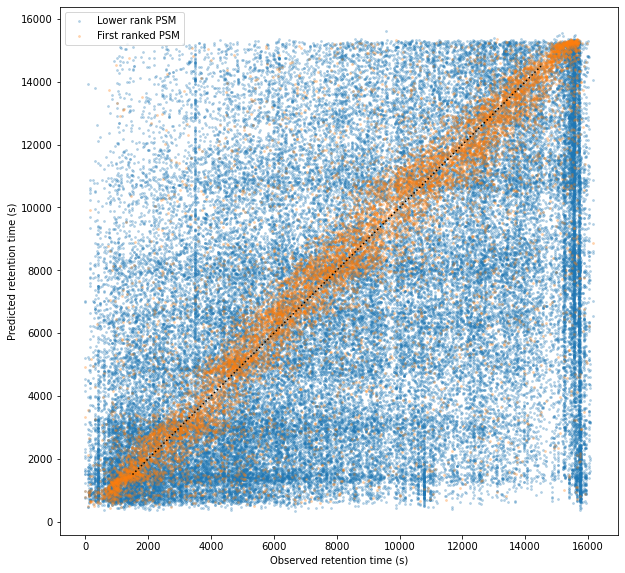

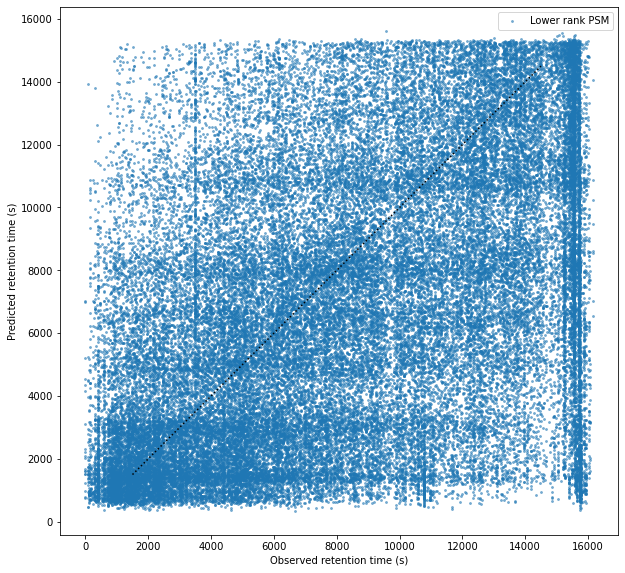

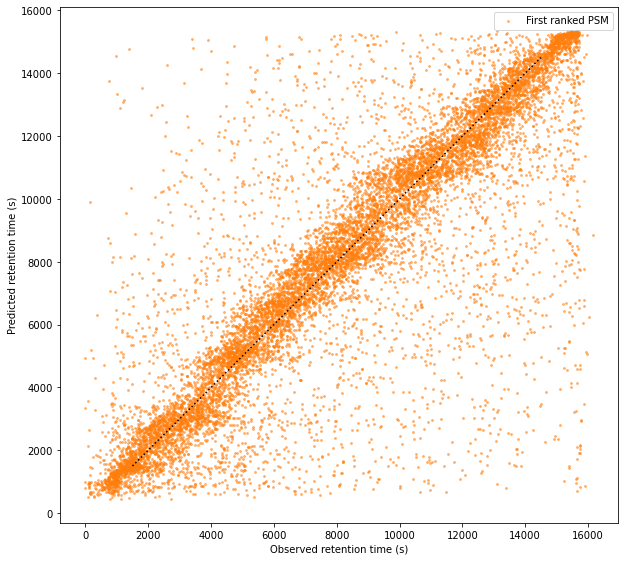

In [15]:
sub_df_pred_lowerrank = sub_df_pred[sub_df_pred["best_psm"]==0]
sub_df_pred_firstrank = sub_df_pred[sub_df_pred["best_psm"]==1]

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_pred_lowerrank["tr"],sub_df_pred_lowerrank["preds"],s=3.5, alpha=0.25,label="Lower rank PSM")
plt.scatter(sub_df_pred_firstrank["tr"],sub_df_pred_firstrank["preds"],s=3.5, alpha=0.25,label="First ranked PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_pred_lowerrank["tr"],sub_df_pred_lowerrank["preds"],s=3.5, alpha=0.5, color="tab:blue",label="Lower rank PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_pred_firstrank["tr"],sub_df_pred_firstrank["preds"],s=3.5, alpha=0.5, color="tab:orange",label="First ranked PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

## 2.2.2 Questions - prediction errors of (ranked) PSMs

<ol>
  <li>Is there a difference in error between different ranked PSMs?</li>
  <li>What do you think the error distributions look like of these two classes?</li>
  <li>Why are there both horizontal and vertical streeks visible?</li>
</ol>

Execute the following cell to see the error distributions:

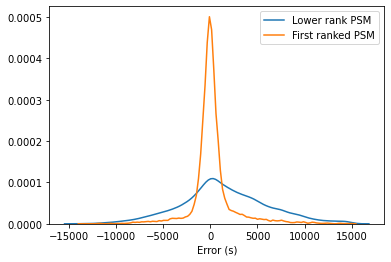

In [16]:
sns.distplot(sub_df_pred_lowerrank["tr"]-sub_df_pred_lowerrank["preds"],
             hist = False, kde = True, label="Lower rank PSM")
sns.distplot(sub_df_pred_firstrank["tr"]-sub_df_pred_firstrank["preds"],
             hist = False, kde = True, label="First ranked PSM")
plt.xlabel("Error (s)")
plt.show()

# 2.3 Predict retention times of modified peptides

## 2.3.1 Effect of modifications on retention time

In [17]:
def plot_modification(sub_df_best,modification="carbamidomethyl"):
    # Init plot
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    ax.set_aspect('equal')

    # Plot data
    plt.scatter(sub_df_best[sub_df_best["modifications"].str.contains(modification)]["tr"],sub_df_best[sub_df_best["modifications"].str.contains(modification)]["preds"],alpha=0.5,s=4)
    plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")
    
    plt.title(modification)
    plt.xlabel("Observed retention time (s)")
    plt.ylabel("Predicted retention time (s)")
    
    plt.show()

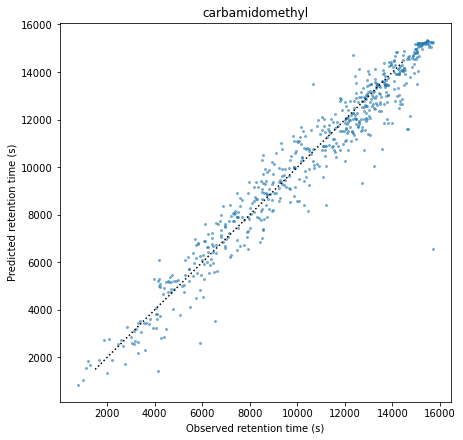

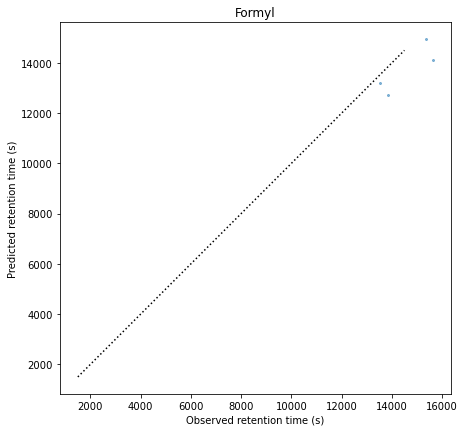

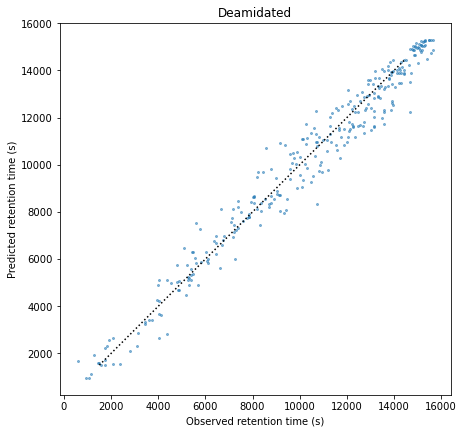

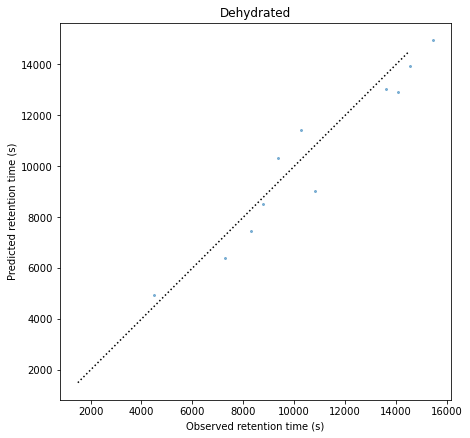

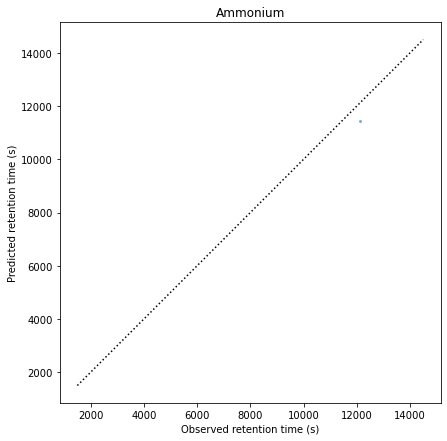

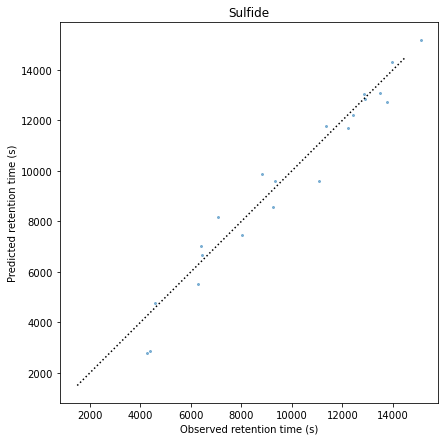

In [18]:
sub_df_best = sub_df_pred[sub_df_pred["best_psm"]==1]
sub_df_best = sub_df_best[sub_df_best["q_value"]<0.001]

plot_modification(sub_df_best,modification="carbamidomethyl")
plot_modification(sub_df_best,modification="Formyl")
plot_modification(sub_df_best,modification="Deamidated")
plot_modification(sub_df_best,modification="Dehydrated")
plot_modification(sub_df_best,modification="Ammonium")
plot_modification(sub_df_best,modification="Sulfide")

## 2.3.2 Questions - retention time prediction of modified peptides

<ol>
  <li>Would it be hard for a model to predict retention times of modifications that was not trained on?</li>
  <li>What modifications would be hardest?</li>
</ol>

# 2.4 Playground - design your own peptides and modifications and predict their retention time

## 2.4.1 Make predictions for your own peptide and modifications combos

Provide the data for peptides you want to predict:

In [19]:
#IIVINTPNNPIGK
dict_effect_aa = {
    "seq" : ["IIVINKPNNPIGK", "IIVINTPNNPIGK", "IIVINAPNNPIGK", "IIVINWPNNPIGK"],
    "modifications" : ["","","",""],
    "tr" : [0,1,2,3]
}

df_effect_aa = pd.DataFrame(dict_effect_aa)

In [20]:
preds = dlc.make_preds(seq_df=df_effect_aa)

Going to predict retention times for this amount of identifiers: 4
Using this amount of identifiers from the library: 0


Lets have a look at their predictions:

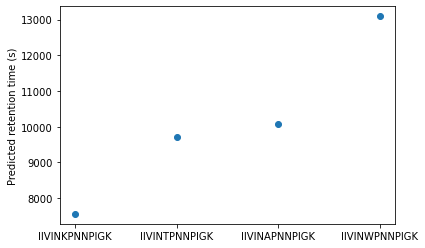

In [21]:
plt.scatter(df_effect_aa.index,preds)
plt.xticks(df_effect_aa.index,df_effect_aa["seq"])
plt.ylabel("Predicted retention time (s)")
plt.show()

Provide the data for peptides+modifications you want to predict:

In [22]:
#IIVINTPNNPIGK
dict_effect_aa = {
    "seq" : ["IIVINCPNNPIGK", "IIVINCPNNPIGK", "IIVINQPNNPIGK", "IIVINQPNNPIGK", "IIVINMPNNPIGK", "IIVINMPNNPIGK"],
    "modifications" : ["","6|carbamidomethyl","","6|Deamidated","","6|Formyl"],
    "tr" : [0,1,2,3,4,5]
}

df_effect_aa = pd.DataFrame(dict_effect_aa)

In [23]:
preds = dlc.make_preds(seq_df=df_effect_aa)

Going to predict retention times for this amount of identifiers: 6
Using this amount of identifiers from the library: 0


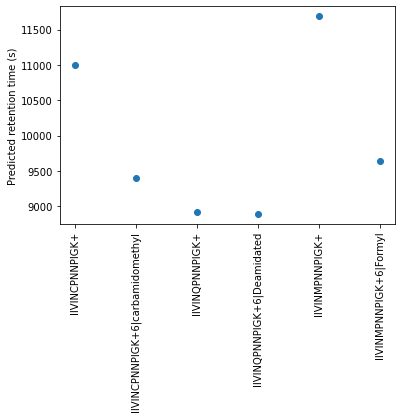

In [24]:
plt.scatter(df_effect_aa.index,preds)
plt.xticks(df_effect_aa.index,df_effect_aa["seq"]+"+"+df_effect_aa["modifications"],rotation=90)
plt.ylabel("Predicted retention time (s)")
plt.show()

## 2.4.2 Questions - playground retention time prediction

<ol>
  <li>Can you design a peptide that falls in between "IIVINKPNNPIGK" and "IIVINTPNNPIGK" in terms of retention time?</li>
  <li>What effect do certain modifications have? Is this expected?</li>
  <li>Do you expect that modifications always have the same effect?</li>
</ol>